# Node2Vec

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from node2vec import Node2Vec as n2v
from itertools import combinations, groupby
sns.set()

## Generate Data

## Create Graph

In [2]:
def generate_graph_deg_dist(deg_dist, n):
    '''
    This function will generate a networkx graph G based on a degree distribution
    provided by the user.
    
    params:
        deg_dist (Dictionary) : The key will be the degree and the value is the probability
                                of a node having that degree. The probabilities must sum to
                                1
        n (Integer) : The number of nodes you want the graph to yield
                          
    example:
        G = generate_graph_deg_dist(
                deg_dist = {
                    6:0.2,
                    3:0.14,
                    8:0.35,
                    4:0.3,
                    11:0.01
                },
                n = 1000
        )
    '''
    deg = list(deg_dist.keys())
    proba = list(deg_dist.values())
    if sum(proba) == 1.:
        deg_sequence = np.random.choice(
            deg,
            n,
            proba
        )
        return nx.configuration_model(deg_sequence)
    raise ValueError("Probabilities do not equal to 1")

In [4]:
G = generate_graph_deg_dist(
        deg_dist = {
            6:0.2,
            3:0.14,
            8:0.35,
            4:0.3,
            11:0.01
        },
        n = 1000
)

In [5]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 1000
Number of edges: 3215
Average degree:   6.4300


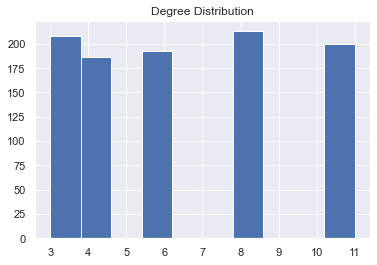

In [6]:
plt.clf()
plt.hist(list(dict(G.degree()).values()))
plt.title('Degree Distribution')
plt.show()

In [7]:
def generate_graph(n, p, dt = nx.MultiGraph()):
    '''
    This function will generate a graph G based on the users input parameters
    source : https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx
    
    params:
        n (Integer) : The number of nodes you would like in the graph
        p (Float) : The probability of adding an edge between nodes
        dt (Function) : The type of the graph you want to create
    
    returns:
        A networkx graph
    
    example:
        G = generate_graph(
            n = 1000,
            p = 0.15,
            dt = nx.MultiGraph()
        )
    '''
    edges = combinations(range(n), 2)
    G = dt
    G.add_nodes_from(range(n))
    
    if p <= 0:
        return G
    elif p >= 1:
        return nx.complete_graph(n, create_using = G)
    else:
        for _, ne in groupby(edges, key = lambda x : x[0]):
            ne = list(ne)
            re = random.choice(ne)
            G.add_edge(*re)
            for e in ne:
                if random.random() < p:
                    G.add_edge(*e)
    return G

In [8]:
# G = generate_graph(n = 1000, p = 0.15, dt = nx.MultiGraph())

## Node2Vec

**Parameter Info**  
- graph: a graph g, where all nodes must be integers or strings  
- dimensions: embedding dimensions (default: 128)  
- walk_length: number of nodes in each walk (default: 80)  
- num_walks: number of walks per node (default: 10)  
- weight_key: the key for the weight attribute on weighted graphs (default: 'weight')  
- workers: number of workers for parallel execution (default: 1)
- p: the probability of a random walk getting back to the previous node (default: 1)
- q: probability that a random walk can pass through a previously unseen part of the graph (default: 1)

Node2Vec.fit method: Accepts any key word argument acceptable by gensim.Word2Vec

In [9]:
%time g_emb = n2v(G, dimensions=16)

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

CPU times: user 17.3 s, sys: 137 ms, total: 17.5 s
Wall time: 17.5 s


In [10]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

In [11]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

In [16]:
input_node = '1'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

('433', 0.8332405090332031)
('277', 0.8205791115760803)
('14', 0.7698894739151001)
('340', 0.7587181329727173)
('777', 0.7562111020088196)
('770', 0.7561677694320679)
('647', 0.7538766264915466)
('415', 0.7531223893165588)
('389', 0.7500568628311157)
('428', 0.7285109758377075)


## Convert to DataFrame

In [ ]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

In [ ]:
emb_df.iloc[:,1:]

### Visualize Embedding

In [ ]:
plt.clf()
fig=plt.figure(figsize=(10,8))
plt.scatter(
    x = emb_df.iloc[:,0],
    y = emb_df.iloc[:,1],
    s = 0.2
)
plt.show()


### PCA

In [ ]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

In [ ]:
emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

In [ ]:
sns.pairplot(emb_df_PCA)

---